In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np


In [16]:
import sys
import os

# Add the path to utils.py
sys.path.append(r"c:\Document\Serieux\Travail\python_work\cEBNM_torch\py")

# Import utils.py directly
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *

Defining the model

In [29]:

# VAE model with positions as input to the decoder
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim, position_dim):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder (we now need to concatenate the latent variable z and position, so hidden_dim + position_dim)
        self.fc2 = nn.Linear(latent_dim + position_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, positions):
    # Ensure positions is of the same dimensionality as z
         if positions.dim() == 1:
            positions = positions.unsqueeze(1)  # Add an extra dimension if needed

    # Concatenate latent variable z with positions
         z_with_positions = torch.cat((z, positions), dim=1)
    
    # Pass through the decoder
         h = F.relu(self.fc2(z_with_positions))
         return self.softmax(self.fc3(h))
    
    def forward(self, x, positions):
        mu, logvar = self.encode(x.view(-1, 784))  # MNIST image input flattened
        z = self.reparameterize(mu, logvar)
        return self.decode(z, positions), mu, logvar


class CustomLikelihoodLoss(nn.Module):
    def __init__(self, L_im):
        super(CustomLikelihoodLoss, self).__init__()
        self.L_im = torch.tensor(L_im, dtype=torch.float32)
    
    def forward(self, pi, mu, logvar, batch_idx):
        # Select the relevant rows of L_im for the current batch
        L_im_batch = self.L_im[batch_idx]

        # Reconstruction loss (negative log-likelihood)
        inner_sum = torch.sum(pi * L_im_batch, dim=1)
        recon_loss = -torch.sum(torch.log(inner_sum))
        
        # KL divergence
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        return recon_loss #+ kl_div



Loading data

In [31]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist_data, batch_size=128, shuffle=True)

# Generate L_im (for demonstration, we'll use random values)
L_im = np.random.rand(len(mnist_data), 10)  # 10 classes in MNIST
# Initialize model and optimizer
input_dim = 784  # 28x28 MNIST images
hidden_dim = 400
latent_dim = 20
output_dim = 10  # 10 classes in MNIST
position_dim = 1  # Assuming positions are scalar, set to 1

model = VAE(input_dim, hidden_dim, latent_dim, output_dim, position_dim)  # Pass position_dim here
criterion = CustomLikelihoodLoss(L_im)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [32]:
# Function to generate y values
def generate_y(t, is_even):
    if is_even:
        return np.random.normal(0, 0.1 + 2 * (np.cos(np.pi * t) ** 2))
    else:
        return np.random.normal(0, 0.1 + 2 * (np.sin(np.pi * t) ** 2))


In [33]:
# Custom Dataset class to handle MNIST images and simulated data
class SimulatedMNISTDataset(Dataset):
    def __init__(self, mnist_data, positions, y_values, y_noisy, digits, noise_level):
        """
        Args:
            mnist_data: MNIST dataset
            positions: Array of simulated positions
            y_values: Array of generated y values
            y_noisy: Array of noisy y values
            digits: Array of corresponding digit labels (0-9)
        """
        self.image       = mnist_data 
        self.mnist_data  = mnist_data
        self.positions   = torch.tensor(positions, dtype=torch.float32)
        self.y_values    = torch.tensor(y_values, dtype=torch.float32)
        self.y_noisy     = torch.tensor(y_noisy, dtype=torch.float32)
        self.digits      = torch.tensor(digits, dtype=torch.long)
        self.noise_level = noise_level

    def __len__(self):
        return len(self.mnist_data)

    def __getitem__(self, idx):
        # Get the image and label from MNIST dataset
        image, _ = self.mnist_data[idx]
        
        # Retrieve the corresponding simulated data
        position = self.positions[idx]
        y_value = self.y_values[idx]
        y_noisy_value = self.y_noisy[idx]
        digit = self.digits[idx]
        
        return image, digit, position, y_value, y_noisy_value
    
    def get_Lim (self):
        self.scale = autoselect_scales_mix_norm( betahat   = np.array(self.y_noisy),
                                                 sebetahat = np.array(self.noise_level))
        
        self.Lim  = get_data_loglik_exp (betahat   = np.array(self.y_noisy),
                                         sebetahat = np.array( self.noise_level),
                                         scale     =  self.scale)
        
        
        


In [34]:
# Load MNIST dataset (train set)
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


In [35]:
# Simulation parameters
n_samples = 10000
noise_level=1
# Arrays to store results
positions = []
y_values = []
digits = []
y_noisy = []
idx_image =[]

# Ensure unique indices are used
unique_indices = np.random.choice(len(mnist_data), size=n_samples, replace=False)

# Filter the MNIST dataset using unique indices
filtered_mnist_data = torch.utils.data.Subset(mnist_data, unique_indices)
# Run simulation ensuring unique idx for each sample
for idx in unique_indices:
    # Get MNIST image and its label using unique idx
    image, label = mnist_data[idx]
    
    # Generate random position
    t = np.random.uniform(-0.5, 2.5)
    
    # Determine if digit is even or odd
    is_even = label % 2 == 0
    
    # Generate y value based on t and whether the digit is even or odd
    y = generate_y(t, is_even)
    
    # Add Gaussian noise to y
    noise = np.random.normal(0, noise_level)
    y_noisy_value = y + noise
    
    # Store results
    positions.append(t)
    y_values.append(y)
    y_noisy.append(y_noisy_value)
    digits.append(label)

# Convert lists to numpy arrays
positions = np.array(positions)
y_values = np.array(y_values)
y_noisy = np.array(y_noisy)
digits = np.array(digits)

# Create custom dataset with the filtered MNIST dataset and simulated data
simulated_dataset = SimulatedMNISTDataset( mnist_data = filtered_mnist_data,
                                          positions   = positions, 
                                          y_values    = y_values,
                                          y_noisy     = np.array(y_noisy),
                                          digits      = digits,
                                          noise_level =  np.repeat(1,y_noisy.shape[0]))

In [36]:
autoselect_scales_mix_norm( betahat= np.array(y_noisy),
                                                 sebetahat = np.repeat(1,y_noisy.shape[0]))
simulated_dataset.get_Lim()
 

In [37]:
# Use the custom simulated dataset with the DataLoader
data_loader = DataLoader(simulated_dataset, batch_size=128, shuffle=True)


In [38]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, target, positions, y_values, y_noisy_values) in enumerate(data_loader):
        optimizer.zero_grad()
        
        # Get the batch index for L_im
        indices = target  # Assuming the target corresponds to the indices
        
        # Forward pass through the model, now including positions as input
        pi, mu, logvar = model(data, positions)
        loss = criterion(pi, mu, logvar, indices)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item() / len(data):.4f}')
    
    print(f'====> Epoch: {epoch+1} Average loss: {train_loss / len(data_loader.dataset):.4f}')


Epoch 1, Batch 0, Loss: 0.8534
====> Epoch: 1 Average loss: 0.4291
Epoch 2, Batch 0, Loss: 0.4503
====> Epoch: 2 Average loss: 0.3477
Epoch 3, Batch 0, Loss: 0.3322
====> Epoch: 3 Average loss: 0.3417
Epoch 4, Batch 0, Loss: 0.3307
====> Epoch: 4 Average loss: 0.3390
Epoch 5, Batch 0, Loss: 0.3362
====> Epoch: 5 Average loss: 0.3385
Epoch 6, Batch 0, Loss: 0.3180
====> Epoch: 6 Average loss: 0.3365
Epoch 7, Batch 0, Loss: 0.3077
====> Epoch: 7 Average loss: 0.3348
Epoch 8, Batch 0, Loss: 0.3157
====> Epoch: 8 Average loss: 0.3346
Epoch 9, Batch 0, Loss: 0.2990
====> Epoch: 9 Average loss: 0.3336
Epoch 10, Batch 0, Loss: 0.3088
====> Epoch: 10 Average loss: 0.3334
Epoch 11, Batch 0, Loss: 0.2827
====> Epoch: 11 Average loss: 0.3327
Epoch 12, Batch 0, Loss: 0.2952
====> Epoch: 12 Average loss: 0.3323
Epoch 13, Batch 0, Loss: 0.3372
====> Epoch: 13 Average loss: 0.3331
Epoch 14, Batch 0, Loss: 0.3575
====> Epoch: 14 Average loss: 0.3320
Epoch 15, Batch 0, Loss: 0.3338
====> Epoch: 15 Aver

In [39]:
# Set the model to evaluation mode
model.eval()

# Create a DataLoader for the test dataset or use some batch from the training data
# In this example, we'll use the same data_loader
with torch.no_grad():  # Disable gradient calculations during inference
    for batch_idx, (data, target, positions, y_values, y_noisy_values) in enumerate(data_loader):
        
        # Forward pass to get the predictions
        pi, mu, logvar = model(data, positions)
        
        # Print or save the predicted 'pi' values
        print(f'Predicted pi values for batch {batch_idx}:')
        print(pi)
        
        # If you want to stop after one batch (for demonstration)
        break


Predicted pi values for batch 0:
tensor([[2.2510e-40, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 7.0065e-45,
         0.0000e+00],
        [3.1641e-20, 2.2624e-20, 8.9545e-20,  ..., 7.2193e-21, 1.4395e-15,
         2.1392e-20],
        [1.0000e+00, 3.7989e-16, 1.5110e-16,  ..., 4.9848e-16, 4.6088e-14,
         1.2373e-15],
        ...,
        [6.2621e-32, 3.8089e-34, 3.1130e-33,  ..., 4.8470e-35, 1.6294e-25,
         7.8821e-34],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.1266e-20, 5.7818e-21, 1.4828e-20,  ..., 1.2855e-21, 9.6171e-16,
         6.5508e-21]])


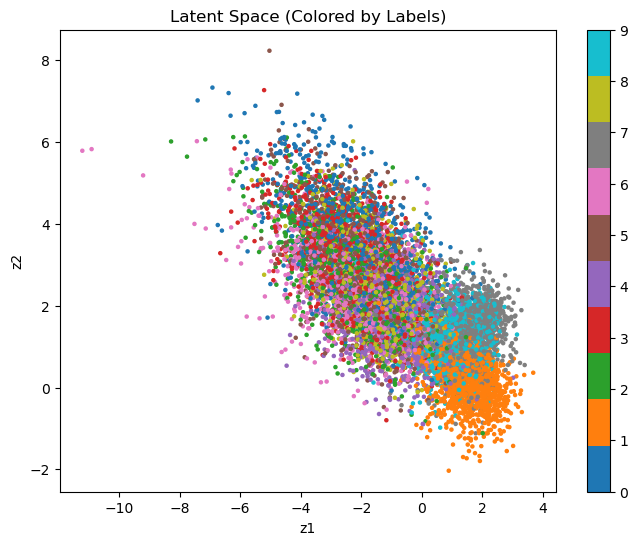

In [40]:
import matplotlib.pyplot as plt
import torch

# Set the model to evaluation mode
model.eval()

# Initialize lists to hold latent variables and corresponding labels
all_z = []
all_labels = []

# Disable gradient calculation during inference
with torch.no_grad():
    for batch_idx, (data, target, positions, y_values, y_noisy_values) in enumerate(data_loader):
        
        # Encode the data to get the latent variables
        mu, logvar = model.encode(data.view(-1, 784))  # Flatten the MNIST images
        z = model.reparameterize(mu, logvar)
        
        # Append the latent variables and labels
        all_z.append(z)
        all_labels.append(target)
    
    # Concatenate all the latent variables and labels from each batch
    all_z = torch.cat(all_z).cpu().numpy()  # Convert to NumPy array for plotting
    all_labels = torch.cat(all_labels).cpu().numpy()

# Plot the latent space
plt.figure(figsize=(8, 6))
plt.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10', s=5)  # Assuming 2D latent space
plt.colorbar()
plt.title('Latent Space (Colored by Labels)')
plt.xlabel('z1')
plt.ylabel('z2')
plt.show()
